# Manual Audit for Bias and Fairness in Clinical Risk Prediction

This notebook implements a manual auditing pipeline to evaluate potential bias and fairness issues in a clinical dataset using statistical analysis and visual inspection. The goal is to establish a strong human baseline for fairness assessment, which will later be compared with insights from LLMs.

The dataset 'Diabetes 130-US Hospitals (1999-2008)' covers around 100,000 inpatient encounters for diabetic patients. It includes demographics, diagnosis codes, hospital admission details, lab tests, and prescribed medications. The dataset was analyzed by Strack et al. to investigate the impact of HbA1c measurement on readmission rates, showing that when HbA1c was measured, patients were slightly less likely to be readmitted within 30 days. 

The audit focuses on:
- Group representation and outcome rates across race, gender, and age group
- Calculation of fairness metrics (Statistical Parity Difference and Disparate Impact Ratio)
- Missing data analysis by subgroup
- Intersectional analysis
- Recommendation rebalancing strategies

Part of the discussion (future work):
- Mutual information

Comparing this manual audit with the insights from LLMs also serves as a foundation for comparing how well LLMs can identify similar patterns or recommend rebalancing strategies.

In [14]:
#Import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.ticker as mtick
from sklearn.feature_selection import mutual_info_classif

In [15]:
#Load dataset
df = pd.read_csv("diabetesdatasets/diabetic_data.csv")

# 1. Group Distribution and Readmission Outcome 

This code creates a new binary variable (readmitted_30) to indicate whether a patient was readmitted to the hospital within 30 days. It then prints the distribution (counts) of patients by race, gender, age, and readmission status. This provides a quick overview of how the key groups and the outcome are represented in the diabetic dataset.

In [16]:
# Make readmission binary (<30 days = 1, else 0)
df["readmitted_30"] = (df["readmitted"] == "<30").astype(int)

# Value counts 
print("Race distribution:\n", df["race"].value_counts(dropna=False))
print("\nGender distribution:\n", df["gender"].value_counts(dropna=False))
print("\nAge distribution:\n", df["age"].value_counts(dropna=False))
print("\nReadmitted distribution:\n", df["readmitted"].value_counts(dropna=False))

Race distribution:
 race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64

Gender distribution:
 gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

Age distribution:
 age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64

Readmitted distribution:
 readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


## 1.1 Output

This output summarizes the composition of the diabetic dataset. Most patients are Caucasian or African American, with smaller numbers from other racial groups and some missing values. The gender split is fairly even between males and females, with almost no unknowns. Most patients are between 50 and 80 years old. Regarding readmission, more than half were not readmitted, about a third were readmitted after 30 days, and about 11% were readmitted within 30 days. 

## 1.2 Visualizations data points

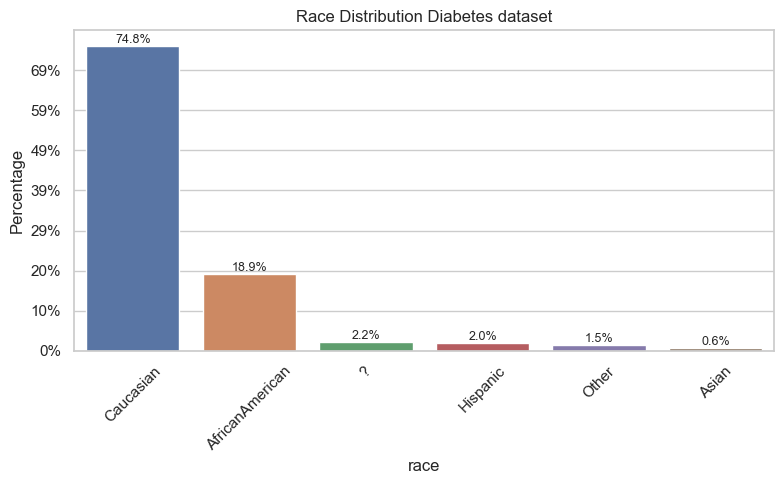

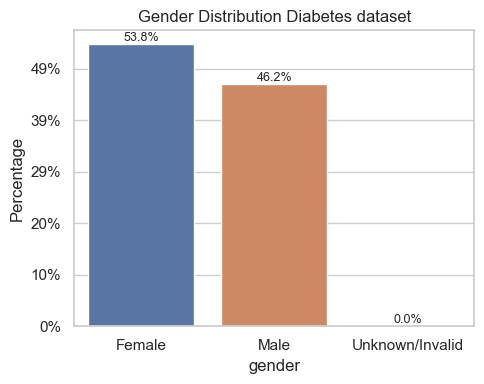

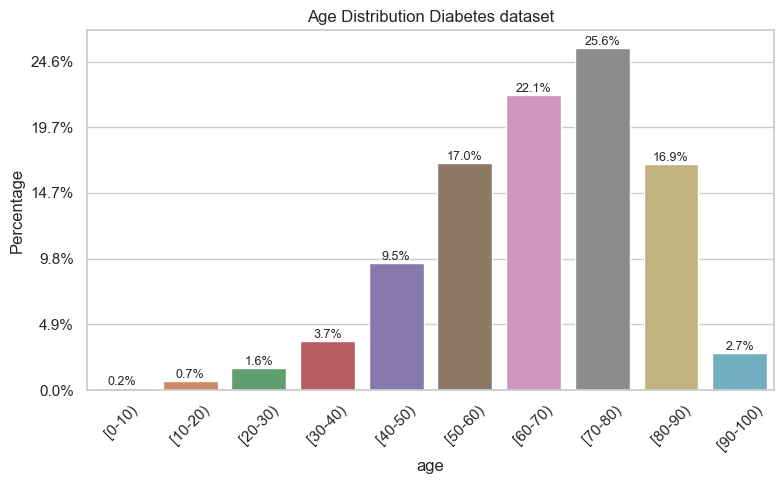

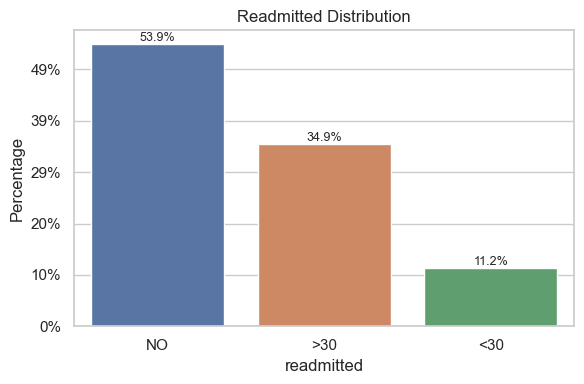

In [17]:
def add_percentage_labels(ax, total):
    for p in ax.patches:
        height = p.get_height()
        percent = 100 * height / total
        ax.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

# Set consistent theme
sns.set(style="whitegrid")

# --- Race Distribution ---
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x="race", order=df["race"].value_counts().index)
total = len(df)
add_percentage_labels(ax, total)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(total))
plt.title("Race Distribution Diabetes dataset")
plt.xticks(rotation=45)
plt.ylabel("Percentage")
plt.tight_layout()
plt.show()

# --- Gender Distribution ---
plt.figure(figsize=(5, 4))
ax = sns.countplot(data=df, x="gender", order=df["gender"].value_counts().index)
total = len(df)
add_percentage_labels(ax, total)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(total))
plt.title("Gender Distribution Diabetes dataset")
plt.ylabel("Percentage")
plt.tight_layout()
plt.show()

# --- Age Distribution ---
age_order = sorted(df["age"].unique())
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x="age", order=age_order)
total = len(df)
add_percentage_labels(ax, total)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(total))
plt.title("Age Distribution Diabetes dataset")
plt.xticks(rotation=45)
plt.ylabel("Percentage")
plt.tight_layout()
plt.show()

# --- Readmitted Distribution ---
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x="readmitted", order=df["readmitted"].value_counts().index)
total = len(df)
add_percentage_labels(ax, total)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(total))
plt.title("Readmitted Distribution")
plt.ylabel("Percentage")
plt.tight_layout()
plt.show()


## 1.3 Grouped 30-Day Readmission Rates

This code calculates and displays the number of patients, the number of 30-day readmissions, and the readmission rate for each race, gender, and age group. It provides a clear overview of which groups have higher or lower short-term readmission rates in the diabetic dataset.

In [18]:
# Grouped readmission rates 
def group_readmission_stats(df, group_col):
    group_stats = (
        df.groupby(group_col)
        .agg(
            total=('readmitted_30', 'size'),
            readmitted_30=('readmitted_30', 'sum')
        )
        .assign(readmission_rate=lambda x: x['readmitted_30'] / x['total']) #calculate positive prediction rate
        .sort_values('total', ascending=False)
    )
    return group_stats

race_stats = group_readmission_stats(df, 'race')
gender_stats = group_readmission_stats(df, 'gender')
age_stats = group_readmission_stats(df, 'age')

print("\nRace readmission stats:\n", race_stats)
print("\nGender readmission stats:\n", gender_stats)
print("\nAge readmission stats:\n", age_stats)


Race readmission stats:
                  total  readmitted_30  readmission_rate
race                                                   
Caucasian        76099           8592          0.112906
AfricanAmerican  19210           2155          0.112181
?                 2273            188          0.082710
Hispanic          2037            212          0.104075
Other             1506            145          0.096282
Asian              641             65          0.101404

Gender readmission stats:
                  total  readmitted_30  readmission_rate
gender                                                 
Female           54708           6152          0.112452
Male             47055           5205          0.110615
Unknown/Invalid      3              0          0.000000

Age readmission stats:
           total  readmitted_30  readmission_rate
age                                             
[70-80)   26068           3069          0.117731
[60-70)   22483           2502          0.1112

## 1.4 Visualization of readmission rates per sensitive feature.

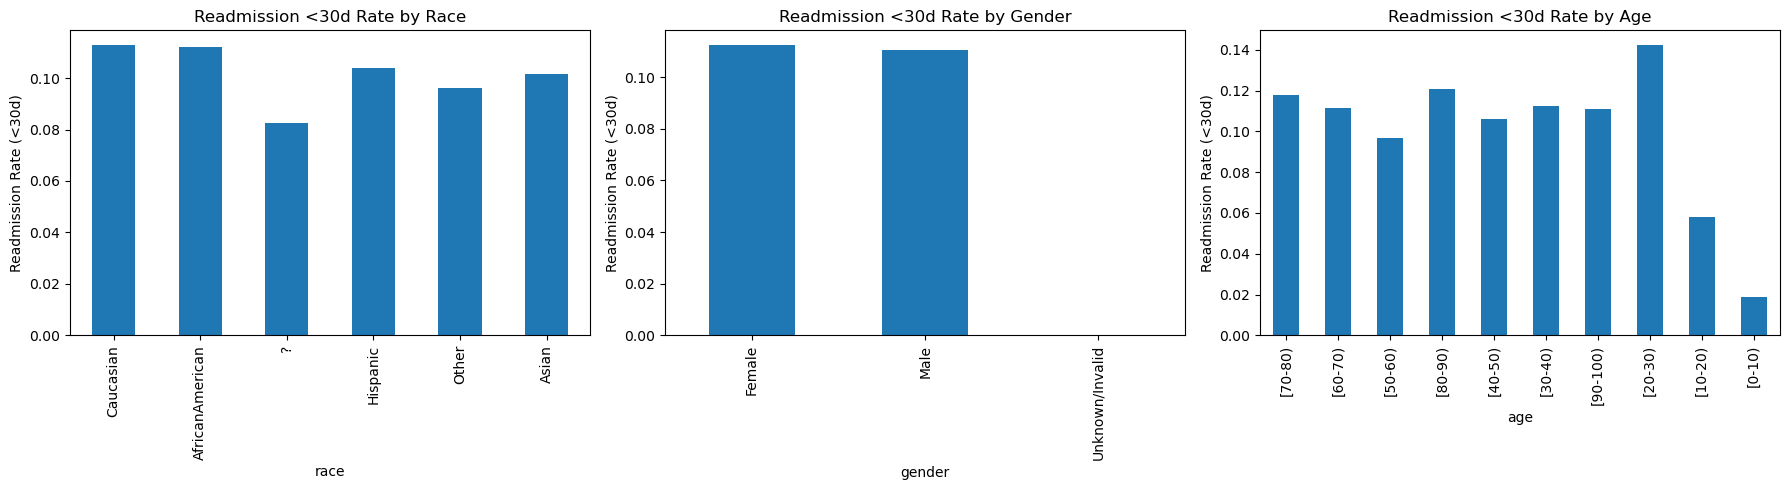

In [22]:
# Bar plot for readmission rates
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

race_stats['readmission_rate'].plot(kind='bar', ax=axes[0], title='Readmission <30d Rate by Race')
gender_stats['readmission_rate'].plot(kind='bar', ax=axes[1], title='Readmission <30d Rate by Gender')
age_stats['readmission_rate'].plot(kind='bar', ax=axes[2], title='Readmission <30d Rate by Age')

for ax in axes: ax.set_ylabel('Readmission Rate (<30d)')

plt.tight_layout()
plt.show()

## 1.5 Output
This output shows 30-day hospital readmission rates by group. Readmission rates are similar across races and genders, with all major groups around 11%. By age, rates are lowest for children and highest for young adults (20–30 years), elderly patients (80–90 years), and those aged 70–80. Overall, certain age groups face a higher risk of early readmission compared to others.

# 2. Fairness Metrics Calculation and applying them

This code adds two fairness metrics, Statistical Parity Difference (SPD) and Disparate Impact Ratio (DIR), to each group’s readmission statistics, comparing every group’s readmission rate to a chosen reference group. This helps identify disparities in readmission outcomes across groups. The code below it sets a reference group for each demographic category and calculates the SPD and DIR for every group relative to that reference. It then displays the readmission rate, SPD, and DIR for each race, gender, and age group, allowing for easy comparison of disparities in 30-day readmission outcomes.

In [19]:
# Fairness metrics 
def compute_fairness(group_stats, ref_group):
    # SPD: group rate - ref group rate
    # DIR: group rate / ref group rate
    ref_rate = group_stats.loc[ref_group, 'readmission_rate']
    group_stats['SPD'] = group_stats['readmission_rate'] - ref_rate
    group_stats['DIR'] = group_stats['readmission_rate'] / ref_rate
    return group_stats

In [20]:
# Set reference groups (largest for each)
race_stats = compute_fairness(race_stats, 'Caucasian')
gender_stats = compute_fairness(gender_stats, 'Female')
age_stats = compute_fairness(age_stats, '[70-80)')

print("\nRace fairness metrics:\n", race_stats[['readmission_rate','SPD','DIR']])
print("\nGender fairness metrics:\n", gender_stats[['readmission_rate','SPD','DIR']])
print("\nAge fairness metrics:\n", age_stats[['readmission_rate','SPD','DIR']])


Race fairness metrics:
                  readmission_rate       SPD       DIR
race                                                 
Caucasian                0.112906  0.000000  1.000000
AfricanAmerican          0.112181 -0.000724  0.993584
?                        0.082710 -0.030195  0.732560
Hispanic                 0.104075 -0.008831  0.921785
Other                    0.096282 -0.016624  0.852762
Asian                    0.101404 -0.011502  0.898132

Gender fairness metrics:
                  readmission_rate       SPD      DIR
gender                                              
Female                   0.112452  0.000000  1.00000
Male                     0.110615 -0.001836  0.98367
Unknown/Invalid          0.000000 -0.112452  0.00000

Age fairness metrics:
           readmission_rate       SPD       DIR
age                                           
[70-80)           0.117731  0.000000  1.000000
[60-70)           0.111284 -0.006446  0.945244
[50-60)           0.096662 -0.021069  0

## 2.1 Output
This output presents fairness metrics for 30-day readmission rates by race, gender, and age group, using each reference group as a baseline (Caucasian for race, Female for gender, and \[70-80) for age). For each group, Statistical Parity Difference (SPD) shows how much higher or lower the readmission rate is compared to the reference, while Disparate Impact Ratio (DIR) expresses the relative rate as a ratio.

Results show that readmission rates are similar between Caucasian and African American patients but lower for other racial groups. Males have a slightly lower readmission rate than females, and the “Unknown/Invalid” gender group has none. Among age groups, young adults (20–30) and the elderly (80–90) have higher readmission rates compared to the reference, while children and younger adults have much lower rates. Overall, these metrics highlight where disparities exist in short-term readmission outcomes.


## 2.2 Visualizations fairness metrics 
This section visualizes the fairness metrics calculated using bar charts for each sensitive attribute (race, gender, and age).


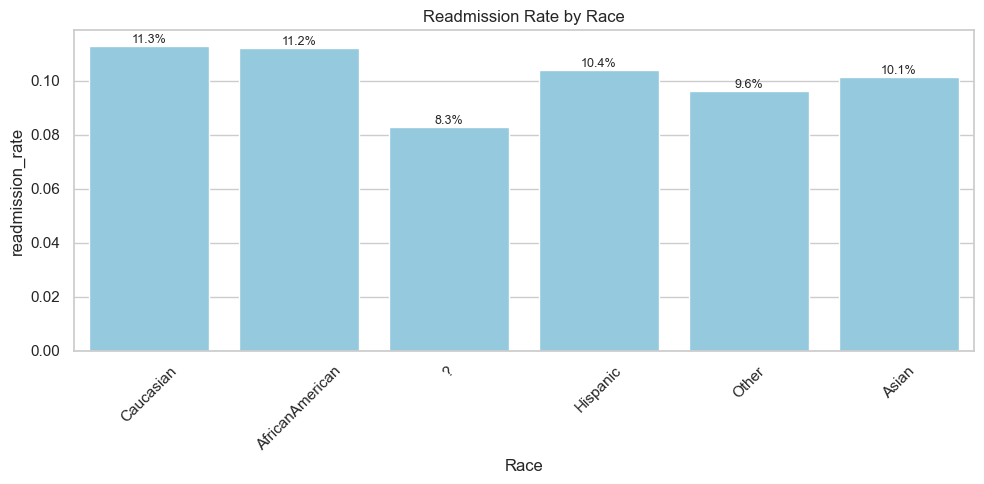

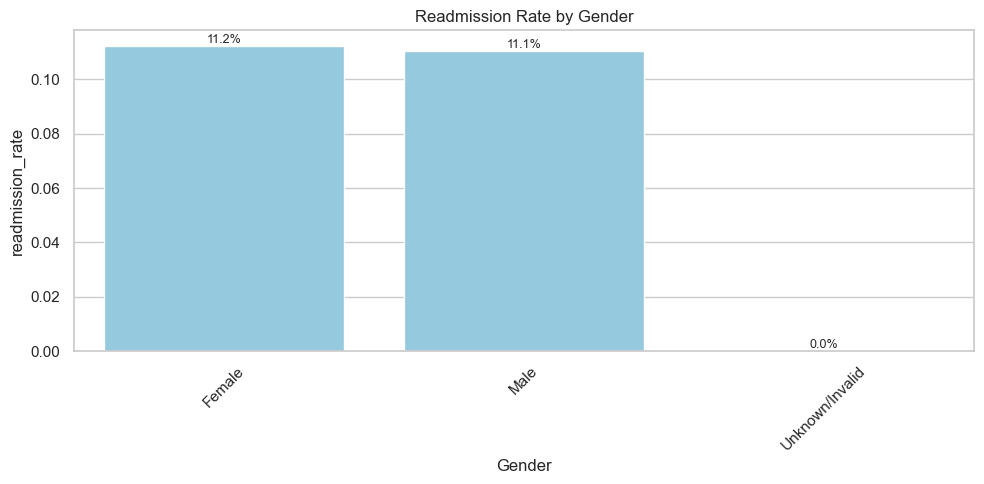

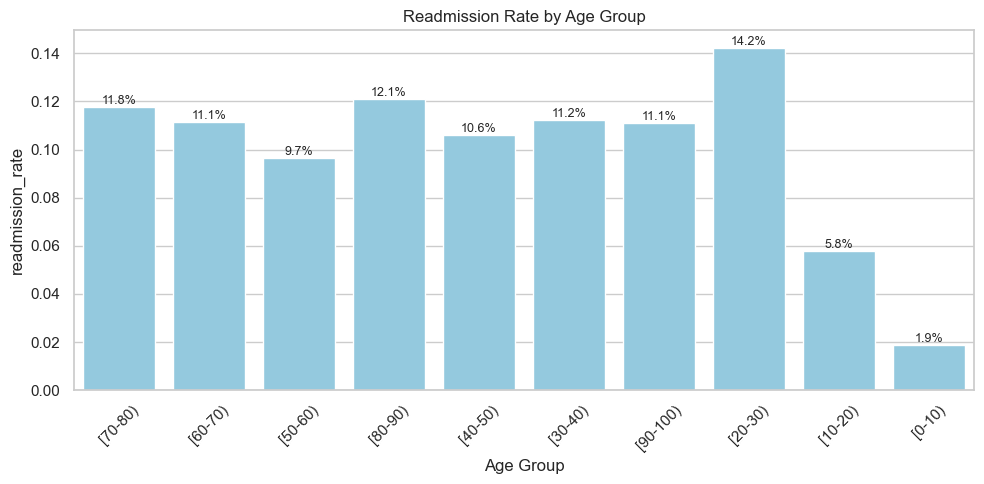

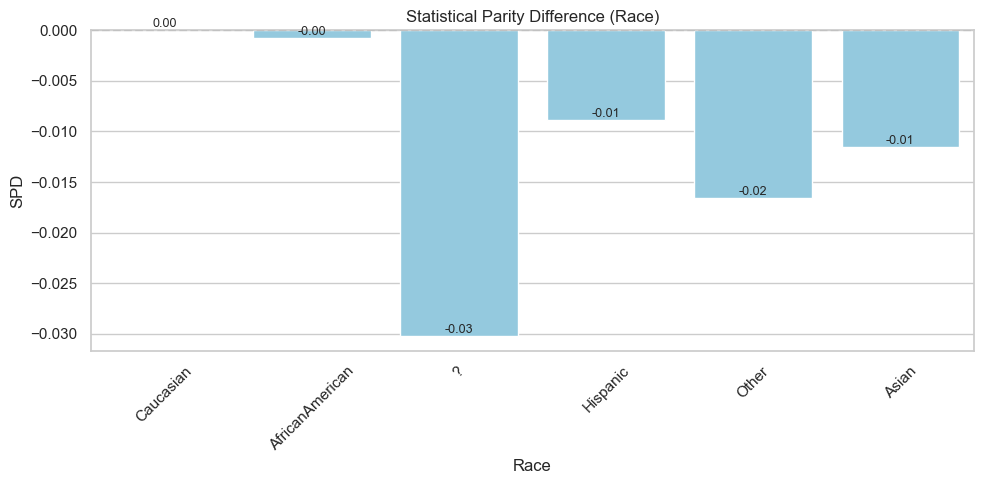

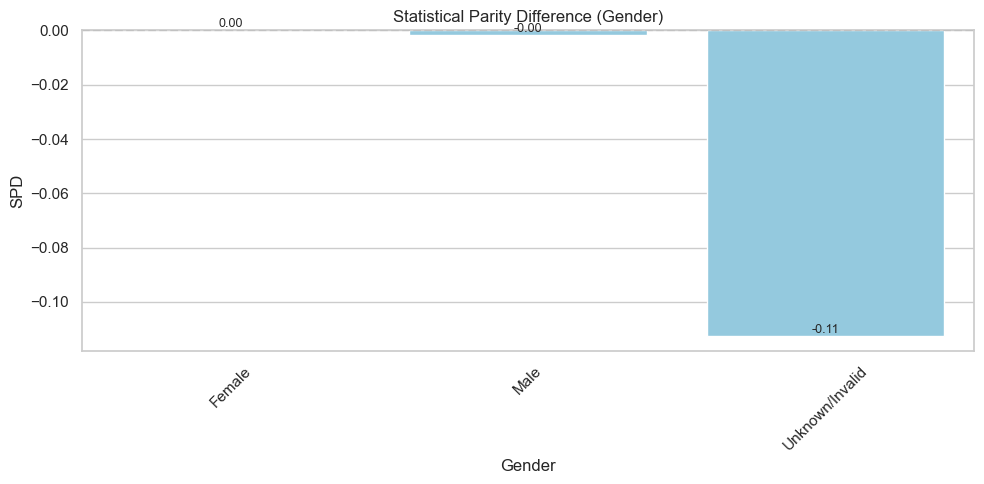

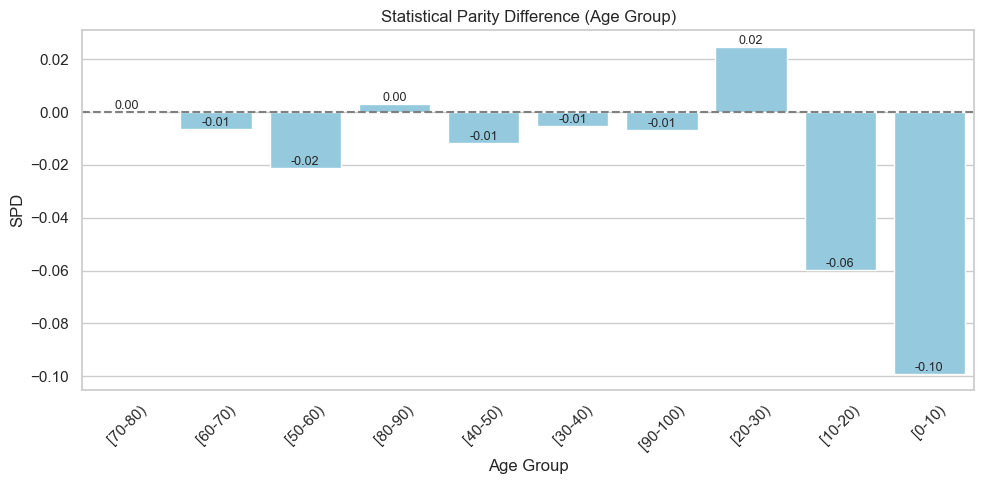

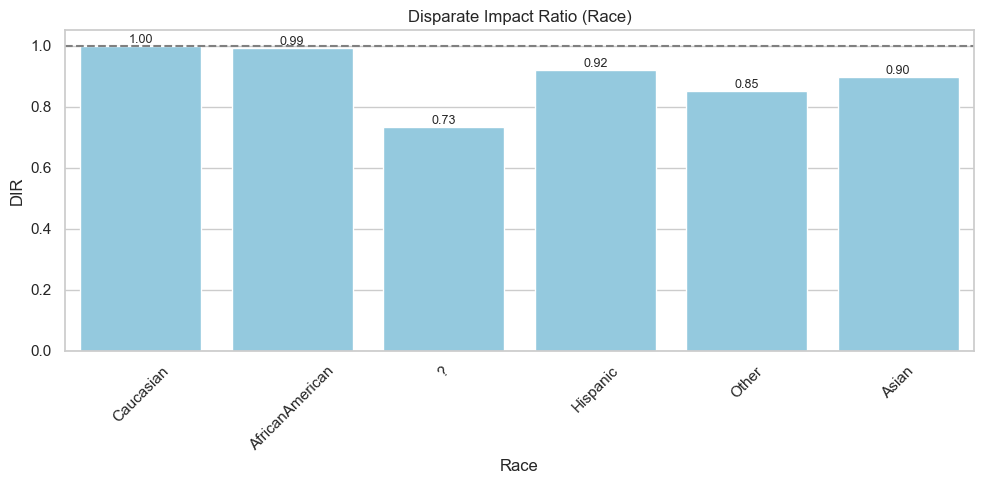

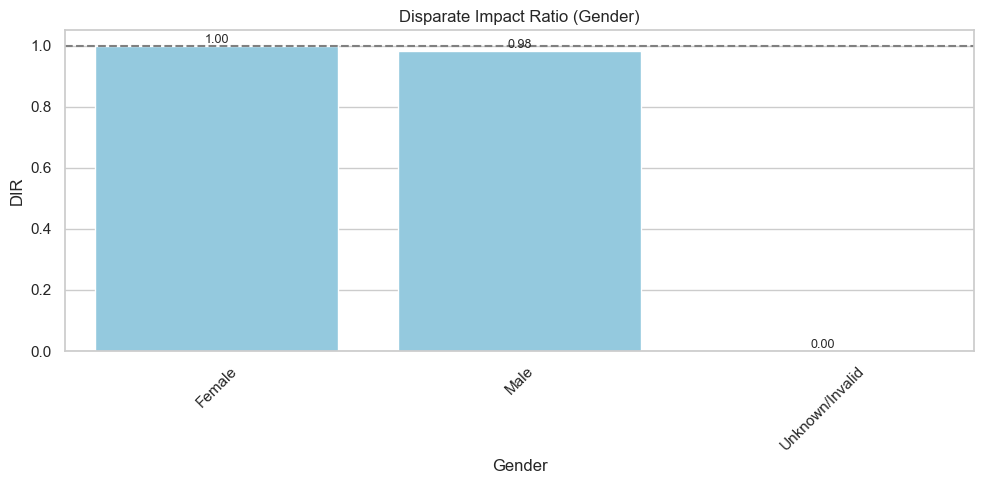

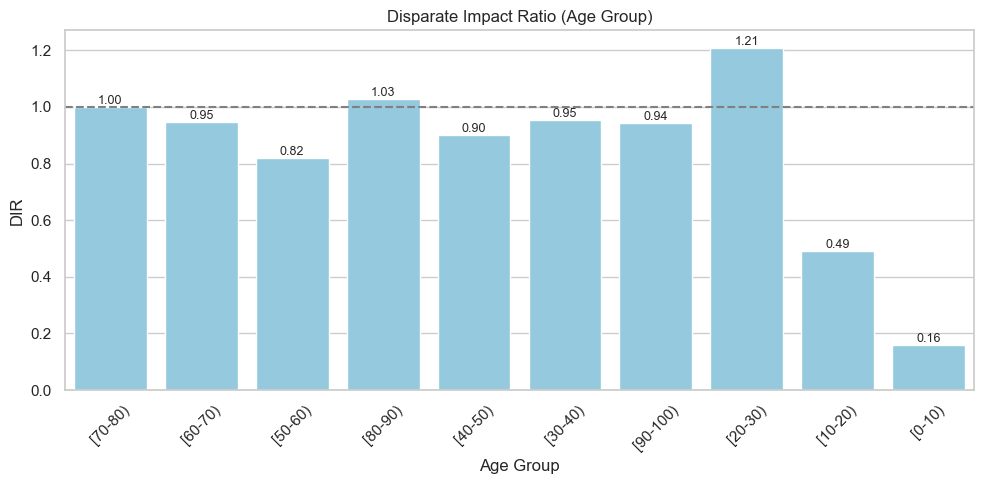

In [21]:
# Set consistent style
sns.set(style="whitegrid")

# Provided fairness metric function 
def compute_fairness(group_stats, ref_group):
    ref_rate = group_stats.loc[ref_group, 'readmission_rate']
    group_stats['SPD'] = group_stats['readmission_rate'] - ref_rate
    group_stats['DIR'] = group_stats['readmission_rate'] / ref_rate
    return group_stats

# Plotting helper 
def plot_fairness(df, group_name, value_column, title, ref_line=None, fmt="{:.1%}"):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=df.index, y=df[value_column], color="skyblue")
    if ref_line is not None:
        plt.axhline(ref_line, color='gray', linestyle='--')
    for p in ax.patches:
        val = p.get_height()
        ax.annotate(fmt.format(val), (p.get_x() + p.get_width() / 2., val),
                    ha='center', va='bottom', fontsize=9)
    plt.title(title)
    plt.xlabel(group_name)
    plt.ylabel(value_column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot Readmission Rate 
plot_fairness(race_stats, "Race", "readmission_rate", "Readmission Rate by Race", fmt="{:.1%}")
plot_fairness(gender_stats, "Gender", "readmission_rate", "Readmission Rate by Gender", fmt="{:.1%}")
plot_fairness(age_stats, "Age Group", "readmission_rate", "Readmission Rate by Age Group", fmt="{:.1%}")

# Plot SPD (Statistical Parity Difference) 
plot_fairness(race_stats, "Race", "SPD", "Statistical Parity Difference (Race)", ref_line=0, fmt="{:.2f}")
plot_fairness(gender_stats, "Gender", "SPD", "Statistical Parity Difference (Gender)", ref_line=0, fmt="{:.2f}")
plot_fairness(age_stats, "Age Group", "SPD", "Statistical Parity Difference (Age Group)", ref_line=0, fmt="{:.2f}")

# Plot DIR (Disparate Impact Ratio) 
plot_fairness(race_stats, "Race", "DIR", "Disparate Impact Ratio (Race)", ref_line=1, fmt="{:.2f}")
plot_fairness(gender_stats, "Gender", "DIR", "Disparate Impact Ratio (Gender)", ref_line=1, fmt="{:.2f}")
plot_fairness(age_stats, "Age Group", "DIR", "Disparate Impact Ratio (Age Group)", ref_line=1, fmt="{:.2f}")


## 2.3 Output

These bar plots above show the number of patients in each race, gender, and age group within the dataset. Most patients are Caucasian, female, and between 50 and 80 years old. There are far fewer patients from other races, non-binary genders, or extreme age groups. 

# 3. Missing data


### Missingness by Race (Top 10 Variables)

|                   |   AfricanAmerican |     Asian |   Caucasian |    Hispanic |     Other |
|:------------------|------------------:|----------:|------------:|------------:|----------:|
| weight            |        99.4118    | 98.5959   | 96.18       | 100         | 98.008    |
| max_glu_serum     |        97.6158    | 95.9438   | 94.0209     |  90.8689    | 95.3519   |
| A1Cresult         |        81.7283    | 78.9392   | 84.0274     |  75.8959    | 79.7477   |
| medical_specialty |        43.0401    | 29.7972   | 50.9415     |  42.9062    | 44.2895   |
| payer_code        |        48.1676    | 41.3417   | 37.492      |  48.7482    | 44.4887   |
| race              |         0         |  0        |  0          |   0         |  0        |
| diag_3            |         1.63457   |  2.4961   |  1.24575    |   2.4055    |  1.46082  |
| diag_2            |         0.307132  |  0.468019 |  0.34166    |   0.589102  |  0.132802 |
| diag_1       

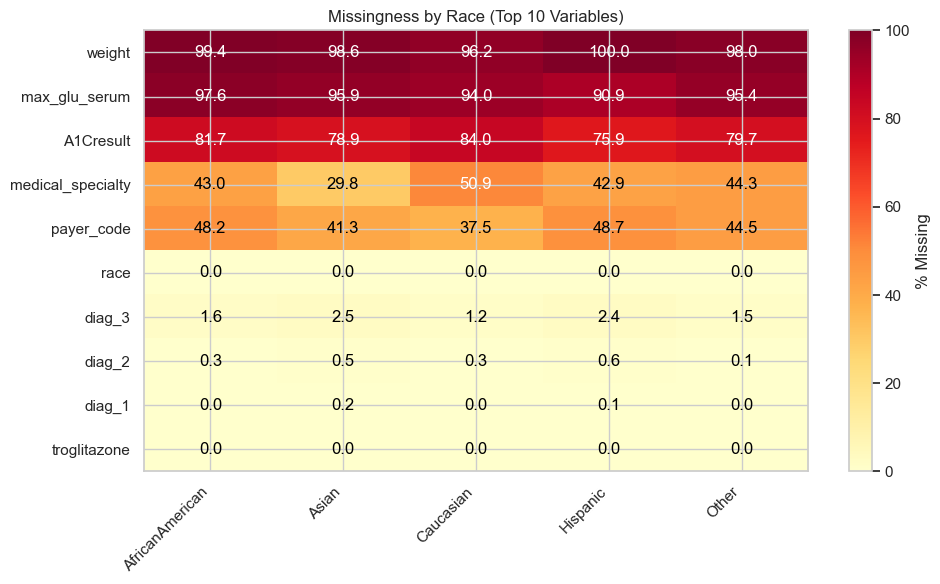

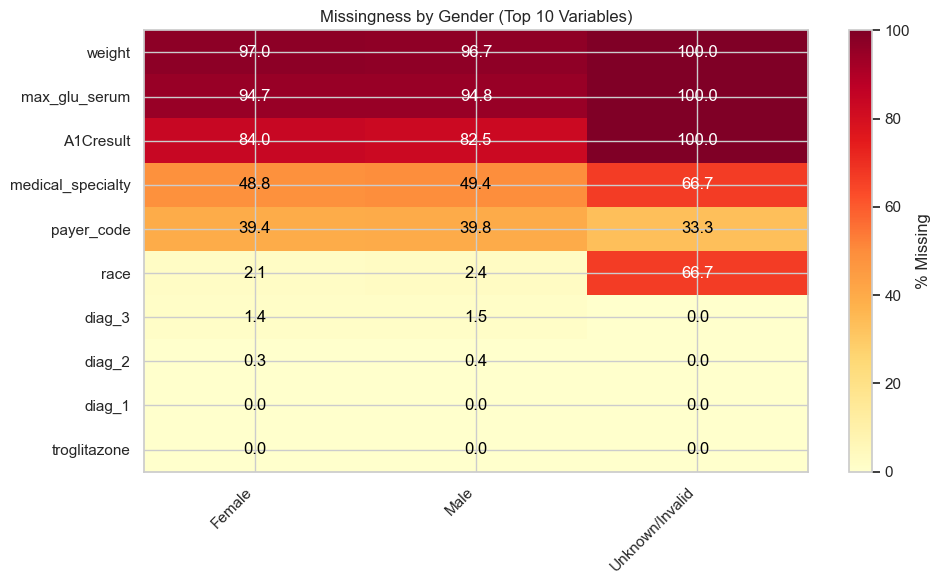

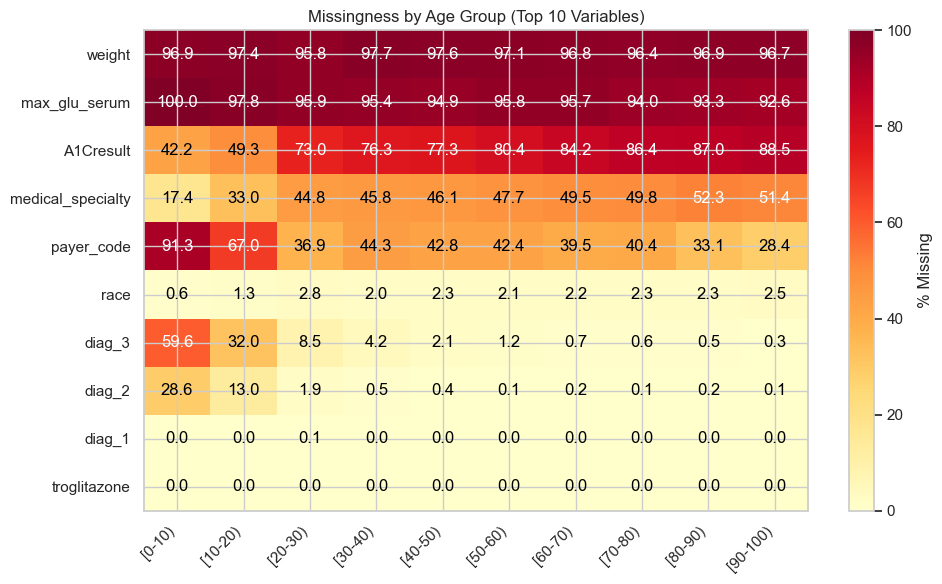

In [36]:
# Load data, treating “?” as NA
df = pd.read_csv("diabetesdatasets/diabetic_data.csv", na_values=["?"], low_memory=False)

# Use existing 'age' bracket column directly
df['age_group'] = df['age']

# Helper to compute per-variable missingness by group
def missing_by_group(df, group_col):
    return (
        df
        .groupby(group_col)
        .apply(lambda g: g.isna().mean() * 100)
        .T
        .sort_index()
    )

# Compute missingness tables for each sensitive attribute
race_missing   = missing_by_group(df, 'race')
gender_missing = missing_by_group(df, 'gender')
age_missing    = missing_by_group(df, 'age_group')

# Identify the top-10 most missing variables overall
top10_vars = df.isna().mean().sort_values(ascending=False).head(10).index

# Print only top-10 rows for each subgroup table
print("\n Missingness by Race (Top 10 Variables)\n")
print(race_missing.loc[top10_vars].to_markdown())

print("\n Missingness by Gender (Top 10 Variables)\n")
print(gender_missing.loc[top10_vars].to_markdown())

print("\n Missingness by Age Group (Top 10 Variables)\n")
print(age_missing.loc[top10_vars].to_markdown())

# Function to plot and annotate a heatmap from a DataFrame
def plot_heatmap(df_subset, title, cmap="YlOrRd"):
    data = df_subset.values
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(data, aspect='auto', cmap=cmap)

    # labels
    ax.set_xticks(np.arange(df_subset.shape[1]))
    ax.set_xticklabels(df_subset.columns, rotation=45, ha='right')
    ax.set_yticks(np.arange(df_subset.shape[0]))
    ax.set_yticklabels(df_subset.index)
    ax.set_title(title)

    # colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('% Missing')

    # annotate each cell
    vmax = np.nanmax(data)
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            val = data[y, x]
            # choose text color based on cell background
            color = 'white' if val > vmax/2 else 'black'
            ax.text(x, y, f"{val:.1f}", ha='center', va='center', color=color)

    plt.tight_layout()
    plt.show()

# Plot heatmaps for each sensitive attribute (top-10 variables)
plot_heatmap(race_missing.loc[top10_vars],
             "Missingness by Race (Top 10 Variables)")
plot_heatmap(gender_missing.loc[top10_vars],
             "Missingness by Gender (Top 10 Variables)")
plot_heatmap(age_missing.loc[top10_vars],
             "Missingness by Age Group (Top 10 Variables)")



Top 10 variables by % missing
|                   |   n_missing |   pct_missing |
|:------------------|------------:|--------------:|
| weight            |       98569 |    96.8585    |
| max_glu_serum     |       96420 |    94.7468    |
| A1Cresult         |       84748 |    83.2773    |
| medical_specialty |       49949 |    49.0822    |
| payer_code        |       40256 |    39.5574    |
| race              |        2273 |     2.23356   |
| diag_3            |        1423 |     1.39831   |
| diag_2            |         358 |     0.351787  |
| diag_1            |          21 |     0.0206356 |
| troglitazone      |           0 |     0         |

Overall missing rate across all cells: 7.21%


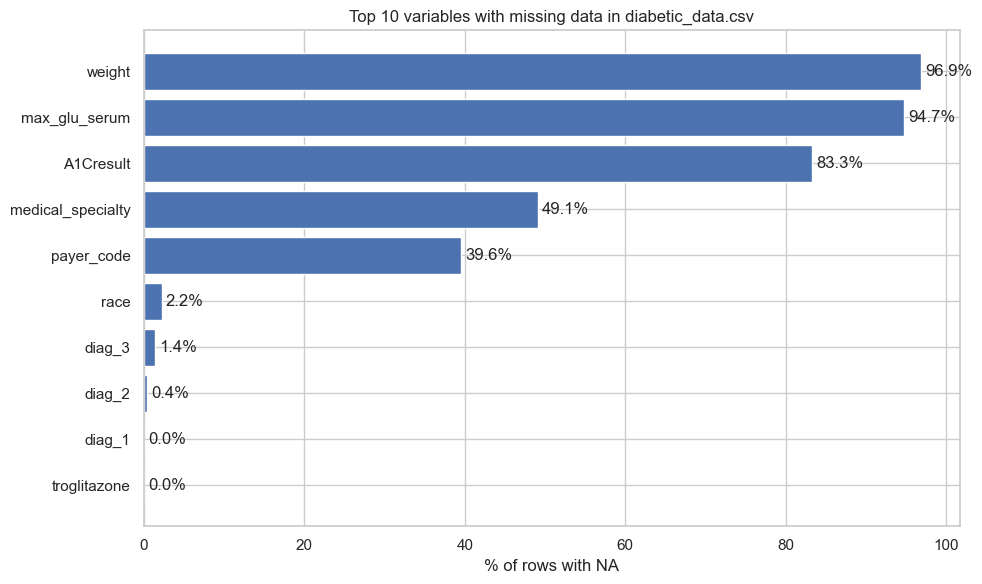

In [40]:
# Per‑column missing counts & percentages
missing = (
    df.isna()
      .agg(['sum', 'mean'])           # sum = N‑missing  |  mean = %‑missing
      .T
      .rename(columns={'sum': 'n_missing', 'mean': 'pct_missing'})
)
missing['pct_missing'] *= 100
missing_sorted = missing.sort_values('pct_missing', ascending=False)

# Display the TOP‑10 variables with the most missing values
print("\nTop 10 variables by % missing")
print(missing_sorted.head(10).to_markdown())

# Overall missing‑rate headline
overall_pct = df.isna().values.mean() * 100
print(f"\nOverall missing rate across all cells: {overall_pct:.2f}%")

# Horizontal bar chart of the top 10 missing‑value offenders
top_n = 10
top_missing = missing_sorted.head(top_n)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_missing.index[::-1], top_missing['pct_missing'][::-1])  # largest bar on top
plt.xlabel('% of rows with NA')
plt.title(f'Top {top_n} variables with missing data in diabetic_data.csv')

# Add text labels showing the percentage
for i, (label, pct) in enumerate(zip(top_missing.index[::-1], top_missing['pct_missing'][::-1])):
    plt.text(pct + 0.5, i, f"{pct:.1f}%", va='center')

plt.tight_layout()
plt.show()


## 3.1 Output missing data

The analysis of missingness across demographic groups reveals substantial variation in data completeness, particularly for clinically relevant variables. Across all racial groups, weight, max_glu_serum, and A1Cresult exhibit the highest levels of missingness, with rates exceeding 80 to 95 percent in most cases. Notably, weight is missing in nearly all records for Hispanic and African American patients, suggesting potential bias in data collection or recording practices.

Gender-based patterns are relatively consistent, although the "Unknown/Invalid" category shows complete missingness for several key variables, including weight, max_glu_serum, and A1Cresult, which raises further concerns about data quality for unclassified entries.

Missingness by age group reveals more nuanced trends. Younger patients, particularly those under 30, show lower completeness for diagnostic and laboratory values, especially A1Cresult and diag_3. In contrast, older age groups generally have more complete records.

# 4. Intersectional Group Analysis

The following code implements an intersectional audit of thirty-day hospital readmission. First, it records the demographic fields, making race and gender categorical strings and preserving the age intervals. The code systematically iterates through each race-gender pair, race-age-band pair, gender-age-band pair, and the full three-way intersection. For each subgroup with at least thirty data points, the code tabulates its population size and computes the mean readmission rate. After running this code, it can be identified which defined demographic intersections experience disproportionately high or low readmission.

In [52]:
pd.set_option('display.max_rows', None)

# Prepare demographic and outcome fields
df['race'] = df['race'].astype(str)                  
df['gender'] = df['gender'].astype(str)            
df['age'] = df['age'].astype(str)                     
# Correctly flag only those readmitted within 30 days
df['readmit_flag'] = (df['readmitted'] == '<30').astype(int)

# Configuration for intersectional slices
min_n   = 30
races   = df['race'].unique()
genders = df['gender'].unique()
ages    = df['age'].unique()

def print_summary(title, rows):
    print(f"\n{title}")
    print(pd.DataFrame(rows).sort_values('n', ascending=False).reset_index(drop=True))

# Race × Gender
rows = []
for race in races:
    for gender in genders:
        sub = df[(df['race'] == race) & (df['gender'] == gender)]
        n = len(sub)
        if n < min_n:
            continue
        rows.append({
            'race': race,
            'gender': gender,
            'n': n,
            'readmit_rate': sub['readmit_flag'].mean()
        })
print_summary('Race × Gender (Readmission Rate)', rows)

# Race × Age Band
rows = []
for race in races:
    for age in ages:
        sub = df[(df['race'] == race) & (df['age'] == age)]
        n = len(sub)
        if n < min_n:
            continue
        rows.append({
            'race': race,
            'age_band': age,
            'n': n,
            'readmit_rate': sub['readmit_flag'].mean()
        })
print_summary('Race × Age Band (Readmission Rate)', rows)

# Gender × Age Band
rows = []
for gender in genders:
    for age in ages:
        sub = df[(df['gender'] == gender) & (df['age'] == age)]
        n = len(sub)
        if n < min_n:
            continue
        rows.append({
            'gender': gender,
            'age_band': age,
            'n': n,
            'readmit_rate': sub['readmit_flag'].mean()
        })
print_summary('Gender × Age Band (Readmission Rate)', rows)

# Race × Gender × Age Band
rows = []
for race in races:
    for gender in genders:
        for age in ages:
            sub = df[(df['race'] == race) & (df['gender'] == gender) & (df['age'] == age)]
            n = len(sub)
            if n < min_n:
                continue
            rows.append({
                'race': race,
                'gender': gender,
                'age_band': age,
                'n': n,
                'readmit_rate': sub['readmit_flag'].mean()
            })
print_summary('Race × Gender × Age Band (Readmission Rate)', rows)


Race × Gender (Readmission Rate)
               race  gender      n  readmit_rate
0         Caucasian  Female  39689      0.114893
1         Caucasian    Male  36410      0.110739
2   AfricanAmerican  Female  11728      0.110846
3   AfricanAmerican    Male   7482      0.114274
4               nan    Male   1138      0.085237
5               nan  Female   1133      0.080318
6          Hispanic  Female   1092      0.091575
7          Hispanic    Male    945      0.118519
8             Other    Male    757      0.089828
9             Other  Female    748      0.102941
10            Asian    Male    323      0.126935
11            Asian  Female    318      0.075472

Race × Age Band (Readmission Rate)
               race  age_band      n  readmit_rate
0         Caucasian   [70-80)  20761      0.118251
1         Caucasian   [60-70)  16693      0.111723
2         Caucasian   [80-90)  14602      0.121148
3         Caucasian   [50-60)  11835      0.099028
4         Caucasian   [40-50)   6131  

### 4.1 Output conclusion: intersectional group analysis
The output reveals that in the Race x Gender breakdown, rates vary from approximately 8.0% among female patients of unknown race to about 12.7% for Asian males, with Caucasian and African American subgroups clustering near 11/11.5%. When stratified by Race x Age band, readmission risk rises from very low levels in young patients (approximately 2.2% in Caucasians aged 0-10) to peaks around 16-17% in adult cohorts such as Caucasians aged 20-30 and Hispanics aged 80-90, before modestly declining in the oldest groups. The Gender x Age band mirrors these trends. The Race × Gender × Age band analysis highlights the variation in readmission rates, ranging from 0 percent in small male cohorts with unknown race aged 30 to 40, to over 19 percent in Caucasian females aged 20 to 30. 

## 4.2 Visualization intersectionality

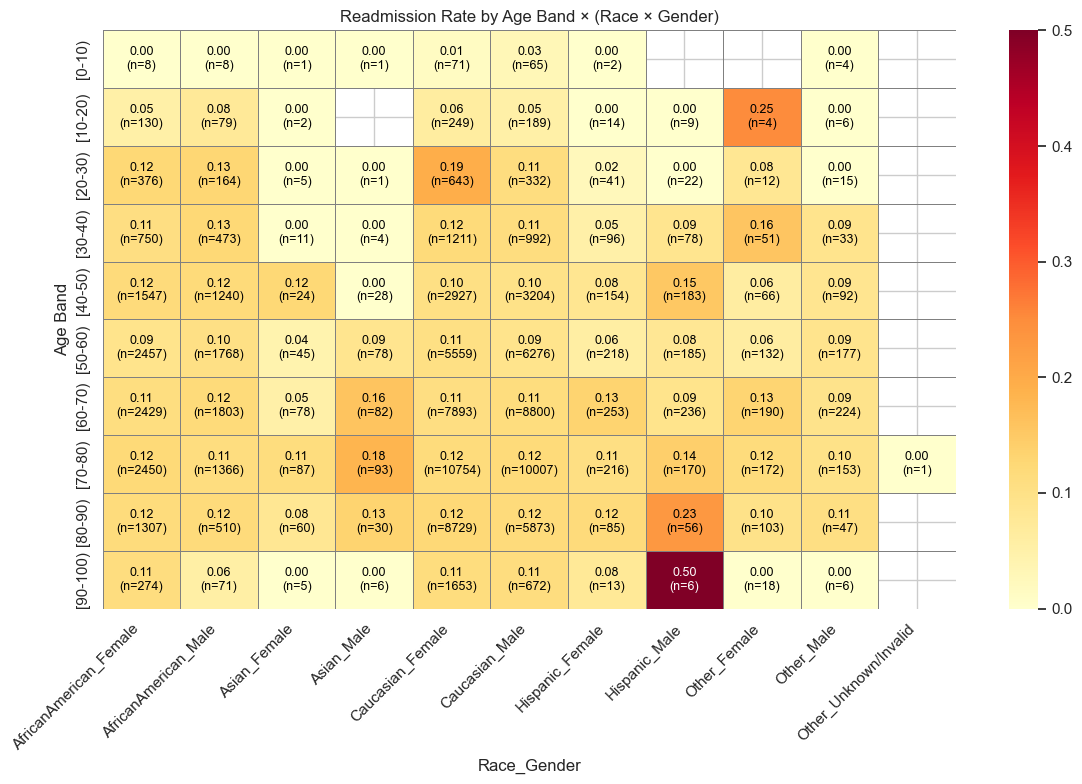

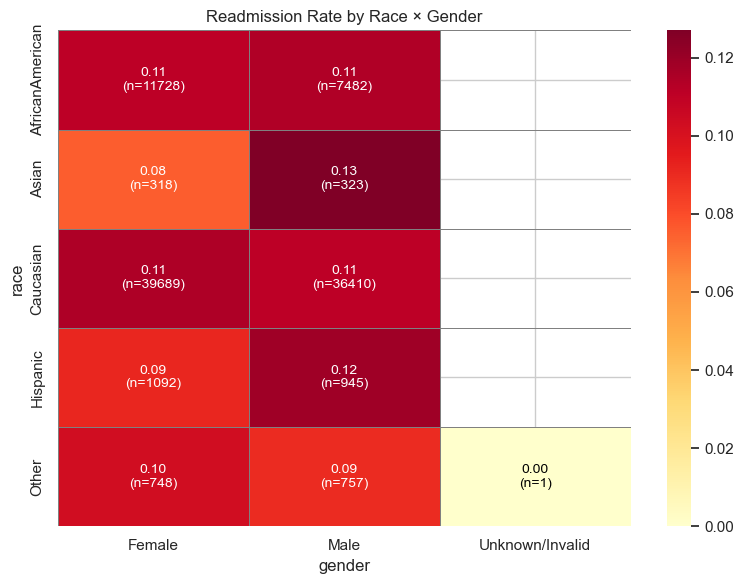

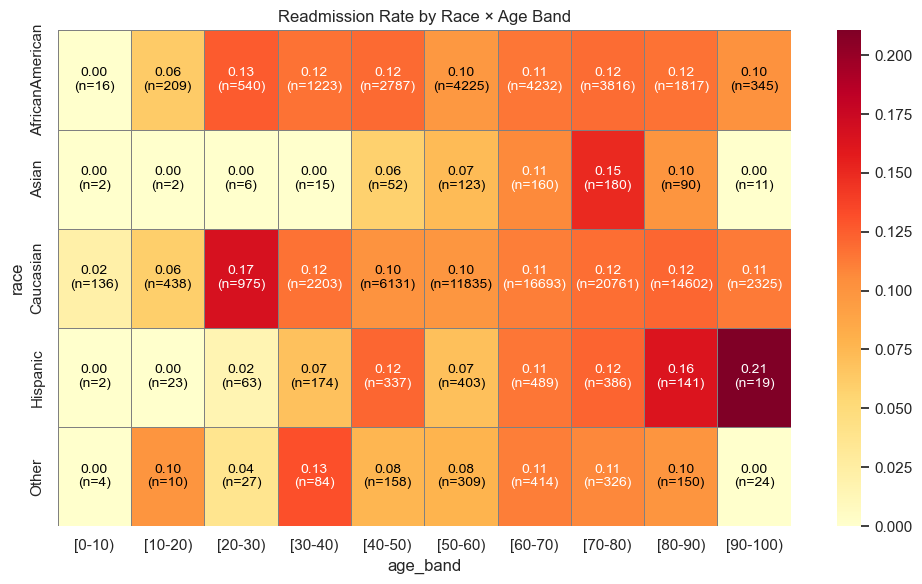

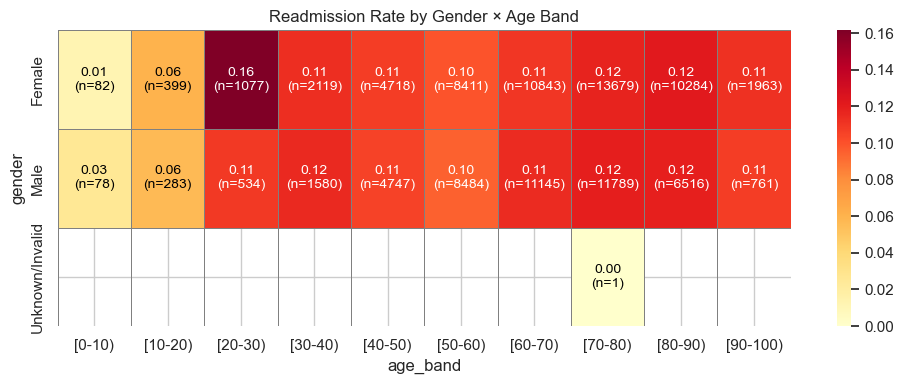

In [60]:
# Combines values race and gender
df['race_gender'] = df['race'] + '_' + df['gender']

# Builds the summary
summary = (
    df.groupby(['age_band','race_gender'])
      .agg(n=('readmit_flag','size'),
           rate=('readmit_flag','mean'))
      .reset_index()
)

# Pivot to matrices
mat_rate  = summary.pivot(index='age_band', columns='race_gender', values='rate')
mat_count = summary.pivot(index='age_band', columns='race_gender', values='n')

# One‐off plotting routine
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    mat_rate,
    mask=mat_rate.isna(),
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar=True,
    annot=False
)

# Renders the four heatmaps:
# Race × Gender x Age

vmax = np.nanmax(mat_rate.values)
for y in range(mat_rate.shape[0]):
    for x in range(mat_rate.shape[1]):
        val = mat_rate.iloc[y, x]
        if np.isnan(val):
            continue
        cnt = int(mat_count.iloc[y, x])
        txt = f"{val:.2f}\n(n={cnt})"
        color = 'white' if val > 0.5 * vmax else 'black'
        ax.text(
            x + 0.5, y + 0.5, txt,
            ha='center', va='center',
            color=color, fontsize=9
        )

ax.set_title('Readmission Rate by Age Band × (Race × Gender)')
ax.set_ylabel('Age Band')
ax.set_xlabel('Race_Gender')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Race × Gender
plot_heatmap_blocks(
    rg, 'race', 'gender',
    'Readmission Rate by Race × Gender'
)

# Race × Age Band
plot_heatmap_blocks(
    ra, 'race', 'age_band',
    'Readmission Rate by Race × Age Band',
    figsize=(10,6)
)

# Gender × Age Band
plot_heatmap_blocks(
    ga, 'gender', 'age_band',
    'Readmission Rate by Gender × Age Band',
    figsize=(10,4)
)


# 5. Rebalancing strategies
The code below evaluates potential biases in the dataset and recommends appropriate rebalancing strategies. The readmitted column is converted into a binary variable, where patients readmitted within 30 days are assigned a value of 1 and all others a value of 0. This binary variable serves as the target for evaluating fairness. The function `recommend_rebalancing` then examines whether sensitivities such as race and gender are fairly represented in the dataset. It identifies underrepresented groups based on a minimum proportion threshold and assesses whether there are significant disparities in outcome rates. Specifically, differences in the likelihood of being readmitted within 30 days between groups. If such gaps are found, the function suggests corrective measures such as oversampling the minority group or applying reweighting techniques to ensure fairness. Additionally, it checks for overall class imbalance in the target variable and recommends strategies like SMOTE or undersampling when necessary. As a final step, it advises the use of stratified sampling during train-test splits to preserve the distribution of sensitive attributes, ensuring that the dataset remains representative throughout the modeling process. 

In [23]:
# Convert readmitted into a binary flag: 1 if readmitted within 30 days (“<30”), else 0
df['readmitted_binary'] = (df['readmitted'] == '<30').astype(int)

def recommend_rebalancing(df, sensitive_cols, target_col="target",
                          min_group_prop=0.1, outcome_imbalance_thresh=0.1):
    """
    Evaluate group representation and outcome rate gaps.
    Returns a dict of recommended strategies for each sensitive feature.
    """
    strategies = defaultdict(list)
    for col in sensitive_cols:
        # Underrepresented categories
        props = df[col].value_counts(normalize=True)
        small = props[props < min_group_prop].index.tolist()
        if small:
            strategies[col].append(f"Oversample underrepresented groups: {small}")

        # Outcome imbalance
        rates = df.groupby(col)[target_col].mean()
        gap = rates.max() - rates.min()
        if gap > outcome_imbalance_thresh:
            strategies[col].append(f"Reweight / fairness correction (gap={gap:.2f})")

    # Global class‐imbalance check
    pos_rate = df[target_col].mean()
    if pos_rate < 0.3 or pos_rate > 0.7:
        strategies["general"].append("Detected class imbalance: consider SMOTE/undersampling/reweighting")

    strategies["general"].append("Use stratified sampling for train-test split")
    return dict(strategies)

# The sensitive features in diabetic_data.csv:
sensitive_features = ["race", "gender"]

# Get and print recommendations
recs = recommend_rebalancing(df, sensitive_features, target_col="readmitted_binary")
for group, notes in recs.items():
    print(f"\n{group.upper()}")
    for note in notes:
        print("- " + note)



RACE
- Oversample underrepresented groups: ['?', 'Hispanic', 'Other', 'Asian']

GENDER
- Oversample underrepresented groups: ['Unknown/Invalid']
- Reweight / fairness correction (gap=0.11)

GENERAL
- Detected class imbalance: consider SMOTE/undersampling/reweighting
- Use stratified sampling for train-test split


## 5.1 Output
The rebalancing analysis indicates that four racial categories: "?", "Hispanic," "Other," and "Asian", each comprise less than 10% of the cohort and should therefore be oversampled to ensure adequate representation. For gender, the "Unknown/Invalid" group similarly falls below the representation threshold, and the observed 11 percentage point gap in 30-day readmission rates between male and female patients exceeds the predefined imbalance criterion, indicating a need for reweighting or other fairness correction methods. The overall readmission rate lies outside the 30-70% range, signaling class imbalance and motivating the application of techniques such as SMOTE, undersampling, or sample weighting. Finally, stratified sampling is advised for train-test splits to preserve subgroup proportions and outcome distributions throughout model development.

# 6. Mutual Information (part of discussion/future work)

The code first visualizes the distribution of race, gender, and age in the dataset using bar plots to highlight group proportions. It then prepares the data for analysis by handling missing values and encoding categorical variables. After preprocessing, it computes mutual information scores to measure how strongly each feature is associated with the readmission outcome. The top 20 features with the highest scores are printed, helping identify which variables are most informative for predicting readmission.

/Users/taramac-lean/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


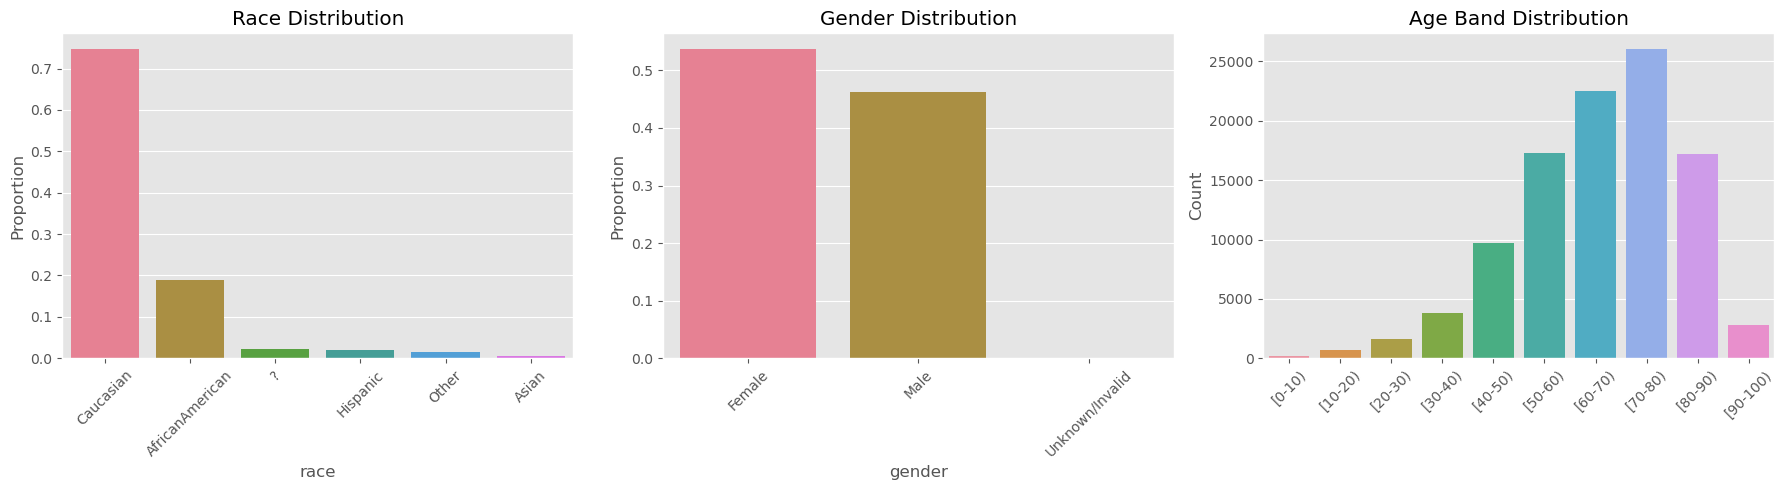

Top 20 features by mutual information with readmission:
readmitted_binary           0.348813
readmitted_30               0.348367
patient_nbr                 0.064695
number_inpatient            0.032022
diag_1                      0.025268
discharge_disposition_id    0.020992
diag_2                      0.020931
diag_3                      0.020154
encounter_id                0.012386
admission_source_id         0.010380
number_emergency            0.008543
num_medications             0.007385
number_diagnoses            0.007317
medical_specialty           0.006953
admission_type_id           0.006781
time_in_hospital            0.004086
number_outpatient           0.003921
payer_code                  0.002607
insulin                     0.002524
diabetesMed                 0.001911
dtype: float64


In [24]:
# Demographic Distributions
# Ensure '?' in race and any unknowns in gender remain as valid categories
df['race']   = df['race'].astype(str)
df['gender'] = df['gender'].astype(str)
df['age']    = df['age'].astype(str)

# Plot settings
plt.style.use('ggplot')
sns.set_palette("husl")

# Create a 1x3 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Race Distribution (Proportion)
race_counts = df['race'].value_counts(normalize=True)
sns.barplot(x=race_counts.index, y=race_counts.values, ax=axes[0])
axes[0].set_title('Race Distribution')
axes[0].set_ylabel('Proportion')
axes[0].tick_params(axis='x', rotation=45)

# Gender Distribution (Proportion)
gender_counts = df['gender'].value_counts(normalize=True)
sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[1])
axes[1].set_title('Gender Distribution')
axes[1].set_ylabel('Proportion')
axes[1].tick_params(axis='x', rotation=45)

# Age Band Distribution (Count)
age_counts = df['age'].value_counts()
# Sort age bands by their numeric lower bound
age_order = sorted(age_counts.index, key=lambda x: int(x.strip('[]()').split('-')[0]))
sns.barplot(x=age_order, y=[age_counts[a] for a in age_order], ax=axes[2])
axes[2].set_title('Age Band Distribution')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Mutual Information Analysis
# Keep '?' in race, but treat '?' elsewhere as missing
cols_except_race = [c for c in df.columns if c != 'race']
df_mi = df.copy()
df_mi[cols_except_race] = df_mi[cols_except_race].replace('?', np.nan)

# Identify numeric vs. categorical columns
numeric_cols     = df_mi.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_mi.select_dtypes(exclude=np.number).columns.tolist()

# Impute numeric columns with median
num_imp = SimpleImputer(strategy='median')
df_mi[numeric_cols] = num_imp.fit_transform(df_mi[numeric_cols])

# Fill missing in categoricals with 'MISSING'
for col in categorical_cols:
    df_mi[col] = df_mi[col].fillna('MISSING')

# Label-encode all categorical features
df_enc = df_mi.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col].astype(str))

# Encode the target variable
target = 'readmitted'
le_tgt = LabelEncoder()
df_enc[target] = le_tgt.fit_transform(df_enc[target].astype(str))

# Prepare feature matrix X and target y
X = df_enc.drop(columns=[target])
y = df_enc[target]
discrete_mask = [col in categorical_cols for col in X.columns]

# Compute mutual information scores
mi = mutual_info_classif(X, y, discrete_features=discrete_mask, random_state=0)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Print the top 20 features by mutual information
print("Top 20 features by mutual information with readmission:")
print(mi_series.head(20))


## 6.1 Output
The output for calculating the mutual information shows that the dataset is demographically imbalanced, with a large overrepresentation of Caucasian patients and a relatively small number of individuals labeled as Asian, Hispanic, or "Other." Gender is relatively balanced but slightly skewed towards females, and the age distribution is concentrated in older age bands, especially between 60 and 80 years. This indicates potential fairness concerns when training models on this data. The mutual information results reveal that no single feature has a dominant influence on predicting readmission, though variables such as `patient_nbr`, `number_inpatient`, and diagnosis codes (`diag_1`, `diag_2`, `diag_3`) carry the most information. Notably, demographic attributes like race, gender, and age do not appear among the top predictors, suggesting that clinical and administrative features have stronger associations with readmission outcomes in this dataset.